# Introduzione

In questa lezione ci occupiamo di implementare l'**Algoritmo Genetico** che è un metodo numerico adatto a risolvere problemi di ottimizzazione. In particolare lo implementiamo per risolvere il problema del commesso viaggiatore in cui ci si propone di trovare quale sia il tragitto minore che collega $N$ diverse città. 

Dal momento che in questo esercizio abbiamo implementato tutto il codice in autonomia, spendo qualche parola per descrivere il modo in cui ho proceduto. 

La prima cosa da descrivere è la forma numerica scelta per descrivere la popolazione di individui. In particolare ho scelto di rappresentare un percorso della popolazione attraverso la `struct Population`:

    struct Population {
        int route[n_cities]={0};
        double fitness=0;
    }.

Vediamo che ogni percorso è caratterizzato da un vettore che rappresenta la sequenza **ordinata** di città da visitare e un valore di fitness che inizialmente viene messo a zero. Dopodichè la popolazione è descritta attraverso due vettori di struct, ossia `vector<Population> current_pop` e `vector<Population> new_pop`. Il primo contine la popolazione dei genitori che lascierà spazio alla popolazione dei figli che è salvata nel secondo vettore. E' importante osservare che entrambi questi vettori sono definiti nell'header file `main.h` e quindi sono accessibili da tutto il programma e vengono progressivamente modificati. 

Procediamo ora a descrivere nel dettaglio il funzionamento del codice.

## `int main()`
Il codice contenuto nel main serve a svolgere le principili operazioni macroscopiche. 


    int main (){

        Input();

        InizialPopulation();
        FitnessPopulation();
        ...

        for (int i=0; i<=n_iter; i++){

            NewPopulation();
            FitnessPopulation();
            ...
            
        }

        return 0;
    }
    
L'algoritmo comincia cun una funzione `Input()` in cui vengono inizializzate le principali variabili del problema fra cui un `vector<vector<int>>` contenente le posizioni delle diverse città. Quest'ultime vengono scelte in modo random su una sfera di raggio $r=1$(./Exercises_09.1) o all'interno di un quadrato di lato $l=1$ (./Exercises_09.2). Dopodiché nella funzione `InizialPopulation()` viene creata una popolazione di percorsi random che fungono da passo iniziale per l'ottimizzazione. Si calcola poi la lunghezza del tragitto per ciascun percorso all'interno della funzione `FitnessPopulation()` . Questo valore svolge il ruole di Fitness e verrà poi usato per selezionare nel passo successivo solo quei tragitti che abbiano un percorso inferiore. In particolare, questa procedura viene svolta nella funzione `NewPopulation()` dove, a partire dai percorsi migliori, si genera una nuova popolazione. Reiterando il processo `n_iter` volte, si converga al tragitto minore. Vediamo ora nel dettaglio la funzione `FitnessPopulation()` e `NewPopulation()`.

## `FitnessPopulation()`
All'interno di questa funzione si svolge per ogni elemento della popolazione un calcolo della Fitness attraverso la funzione `FitnessRoute()`. Dopodichè si ordina la popolazione a partire dal valore minimo al valore massimo di fitness attraverso la funzione `sort(...)`. 

    void FitnessPopulation(void){
        
        for (int i = 0; i < n_pop; i++) 
            current_pop[i].fitness = FitnessRoute(current_pop[i]);
        
        sort(current_pop.begin(), current_pop.end(), compareByFitness);

    }
In particolare, all'interdo della funzione `FitnessRoute()`, per calcolare la Fitness per un dato percorso, abbiamo sommato la distanza fra le diverse città attraverso un ciclo `for{...}`:

    for (int i = 0; i<n_cities; i ++ )
        sum += pow(pow(cities[pop_individual.route[Pbc(i)]][0]-cities[pop_individual.route[Pbc(i+1)]][0],2)+pow(cities[pop_individual.route[Pbc(i)]][1]-cities[pop_individual.route[Pbc(i+1)]][1],2),0.5);

Osserviamo che l'ordine in cui valutare la distanza fra le città è stabilito `pop_individual.route[Pbc(i)]` dove abbiamo usato le periodic boundary conditions `Pbc(...)` per calcolare la distanza fra l'ultima città e la prima. 

## `NewPopulation()`

All'interno di questa funzione, partendo da una popolazione `vector<Population> current_pop()` ordinata in base al valore delle fitness, abbiamo generato una nuova popolazione `vector<Population> new_pop`. Per farlo abbiamo eseguito un ciclo di selezione, crossover e mutazione. Poichè un singolo step di selezione, crossover e mutazione ci restituisce solo due figli, abbiamo ripetuto il tutto attraverso un ciclo`while{..}` fino ad ottenere nuovamente una popolazione di figli in numero uguale a quella dei genitori.  

	while(n<n_pop-1){
		int parent_A = (int) n_pop*pow(rnd.Rannyu(), 5);
		int parent_B = (int) n_pop*pow(rnd.Rannyu(), 5);
        
        child.push_back(current_pop[parent_A]);
        ...

		if(rnd.Rannyu()<r_cross)
			child = RouteCrossover(parent_A,parent_B);
		
		if(rnd.Rannyu()<r_mut)
			child[0] = InversionMutatio(child[0]);
		...
		if(rnd.Rannyu()<r_mut)
			child[0] = PermutationMutation(child[0]);
		...
		if(rnd.Rannyu()<r_mut)
			child[0] = ShiftMutation(child[0]);
		...

		new_pop[n] = child[0];
        ...
	}
    current_pop = new_pop;
    
Osservando più nel dettaglio ogni singolo step, vediamo che la selezione dei genitori avviene attraverso la funzione `n_pop*pow(rnd.Rannyu(), 5)` che privilegia quegli elementi della popolazione con fitness (= percorso) minore. Dopodichè i due genitori generano con probabilità $p=1-$ `r_cross` due figli che sono esattamente uguali a loro mentre con probabilità $p=$`r_cross` i due figli vanno incontro ad un'operazione di crossover. In particolare l'operazione di crossover viene eseguita dalla funzione `RouteCrossover(...)` in cui si eseguo un incrocio dei percorsi dei due genitori a partire da una posizione random `StartCity`. Nell'eseguire questa procedura bisogna prestare attenzione al fatto che non vengano ripetute delle città e noi lo facciamo attraverso il contatore `diff`:

    int StartCity = int(rnd.Rannyu(1,n_cities));

    for (int i=0; i < StartCity; i++)
      child_A.route[i] = current_pop[parent_A].route[i];
	...

	int k = StartCity;
	for(int i =0; i < n_cities; i ++){
		int diff=0;
		for (int j = 0; j < n_cities; j++){
				if (current_pop[parent_A].route[i] == child_B.route[j] ){
					diff+=1;
				}
		}
		if (diff==0){
			child_B.route[k]=current_pop[parent_A].route[i];	
			k++;
		}
	}
    ...
   
I figli così ottenuti vanno incontro ad una serie possibili di mutazioni, tutte con probabilità `r_mut`. Noi ne abbiamo considerate di tre diversi tipi: 
* `InversionMutation(...)`: in questo caso si esegue un semplice scambio fra due città random del percorso
            int City_to_swap_1 = int(rnd.Rannyu() *(n_cities-1))+1;
            int City_to_swap_2 = int(rnd.Rannyu() *(n_cities-1))+1;
* `PermutationMutation(...)`: in questo caso si considera una permutazione del percorso scambiando due vicini scelti in modo random dal percorso
            int City_to_swap_1 = int(rnd.Rannyu(1,n_cities-1));

            int city1 = child.route[City_to_swap_1];
            int city2 = child.route[City_to_swap_1+1];
            
* `ShiftMutation(...)`: in questo caso eseguiamo una traslazione del percorso partendo dalla prima posizione per un numero di città scelto in modo random. Per eseguire questa operazione abbiamo sfruttato la funzione `rotate(...)` della libreria standard convertendo il nostro percorso prima in un `vector<int>`: 

            int City_to_swap =  int(rnd.Rannyu(1,n_cities));
            vector<int> appoggio;

            for (int i = 0; i < n_cities; i++)
                appoggio.push_back(child.route[i]);

            rotate(appoggio.begin()+1,appoggio.begin()+City_to_swap,appoggio.end());

            for (int i = 0; i < n_cities; i++)
                child.route[i]=appoggio[i];



# Cerchio

I parametri usati per la simulazione sono i seguenti:

|  ||
|--------|--------|
|$n_{citta'}$|32|
|$n_{individui}$|1000|
|$n_{generazioni}$|200|
|$r_{crossover}$|0.7|
|$r_{mutazioni}$|0.05|

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
from scipy.optimize import curve_fit
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import subprocess as sb
from os import system
import os
import shutil

sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

In [9]:
path1 = os.path.abspath(os.getcwd())
path = os.path.abspath(os.getcwd())+'/Exercises_09.1/'
os.chdir(path)
os.system('make clean');
os.system('make');
os.system('./main.exe');

In [10]:
cities =  np.loadtxt(path+"cities.dat")
bestFitness =  np.loadtxt(path+"fitness_best.dat")
meanFitness =  np.loadtxt(path+"fitness_mean.dat")


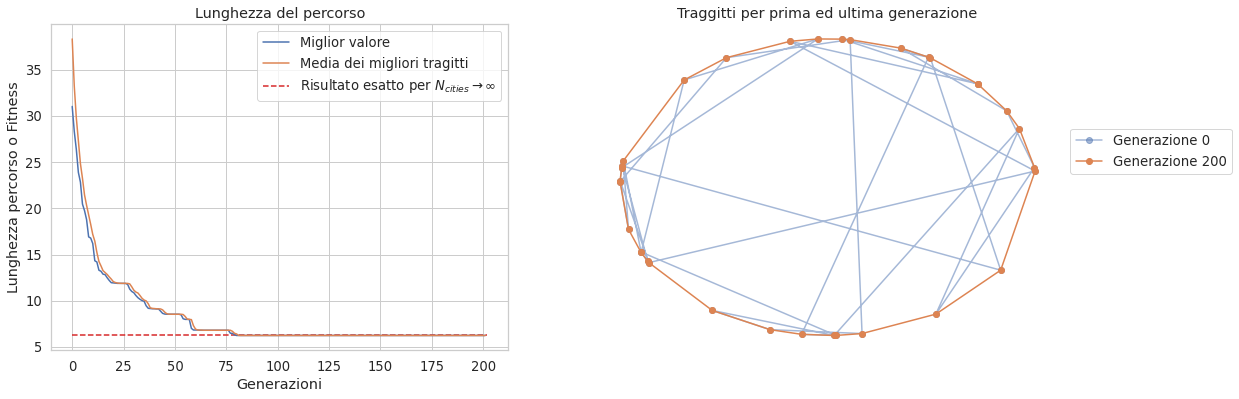

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18,6));  

ax= ax.ravel()


ax[0].plot(bestFitness, label='Miglior valore')
ax[0].plot(meanFitness, label='Media dei migliori tragitti')
ax[0].hlines(6.28319, 0, len(meanFitness), color=plt.cm.tab10(3),linestyle='--', label=r'Risultato esatto per $N_{cities}\rightarrow \infty$');

ax[0].legend()
ax[0].set_title('Lunghezza del percorso')
ax[0].set_xlabel('Generazioni')
ax[0].set_ylabel('Lunghezza percorso o Fitness')

gen = [0,200]
alpha= [0.5,1]

j = 0

for i in gen:
    best_route = np.loadtxt(path+"route_gen_"+str(i)+".dat")
    best_route = best_route.astype(int)
    ax[1].plot(cities[best_route,0], cities[best_route,1], linestyle='-', marker = 'o', label='Generazione '+str(i),alpha=alpha[j])
    j+=1

ax[1].legend(bbox_to_anchor=(1.4,0.7), ncol=1);
ax[1].axis('off');
ax[1].set_title('Traggitti per prima ed ultima generazione');

> Osserviamo che il tragitto migliore è quello che ci aspetteremmo e questo convalida il nostro algortimo. Vediamo inoltre che il tempo richiesto all'algoritmo per converge al percorso migliore è circa 75 generazioni.

# Quadrato

I parametri usati per la simulazione sono i seguenti:

|  ||
|--------|--------|
|$n_{citta'}$|32|
|$n_{individui}$|1000|
|$n_{generazioni}$|200|
|$r_{crossover}$|0.7|
|$r_{mutazioni}$|0.05|

In [12]:
path = path1+'/Exercises_09.2/'
os.chdir(path)
os.system('make clean');
os.system('make');
os.system('./main.exe');

In [13]:
cities =  np.loadtxt(path+"cities.dat")
bestFitness =  np.loadtxt(path+"fitness_best.dat")
meanFitness =  np.loadtxt(path+"fitness_mean.dat")

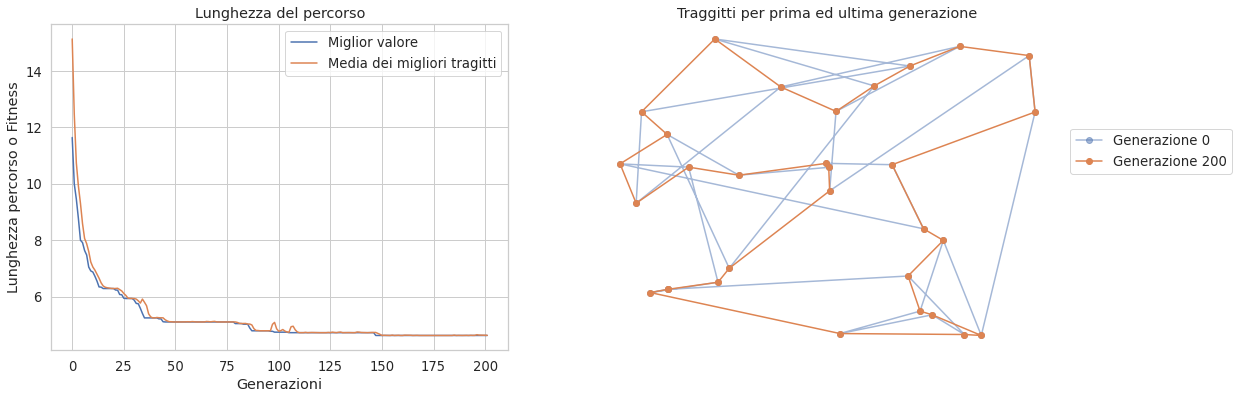

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18,6));  
ax= ax.ravel()


ax[0].plot(bestFitness, label='Miglior valore')
ax[0].plot(meanFitness, label='Media dei migliori tragitti')

ax[0].legend()
ax[0].set_title('Lunghezza del percorso')
ax[0].set_xlabel('Generazioni')
ax[0].set_ylabel('Lunghezza percorso o Fitness')

gen = [0,200]
alpha= [0.5,1]

j = 0

for i in gen:
    best_route = np.loadtxt(path+"route_gen_"+str(i)+".dat")
    best_route = best_route.astype(int)
    ax[1].plot(cities[best_route,0], cities[best_route,1], linestyle='-', marker = 'o', label='Generazione '+str(i),alpha=alpha[j])
    j+=1

ax[1].legend(bbox_to_anchor=(1.4,0.7), ncol=1);
ax[1].axis('off');
ax[1].set_title('Traggitti per prima ed ultima generazione');

> In questo caso non abbiamo la possibilità di confrontare il risultato con una stima a priori, tuttavia potremo confrontarlo con i risultati della prossima lezione. Osserviamo semplicemente che il tempo di convergenza è circa 150 generazioni.